<a href="https://colab.research.google.com/github/dots13/fake_news_detection_Salvador/blob/master/MDFEND/MDFEND_rrss_tests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q transformers einops accelerate langchain bitsandbytes
!pip install faknow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 810.5/810.5 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.2/102.2 MB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 273.9/273.9 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.9/86.9 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.8/144.8 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 40.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━

In [2]:
import torch
from torch import Tensor
from torch import nn
from transformers import BertModel

from faknow.model.layers.layer import TextCNNLayer
from faknow.model.model import AbstractModel

from faknow.data.dataset.text import TextDataset
from faknow.data.process.text_process import TokenizerFromPreTrained
from faknow.evaluate.evaluator import Evaluator
import torch
from torch.utils.data import DataLoader

In [3]:
import joblib
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import numpy as np
import re

In [4]:
from google.colab import drive
import pandas as pd
from faknow.model.content_based.mdfend import MDFEND

In [5]:
drive.mount('/content/gdrive')
path = '/content/gdrive/My Drive/files'

Mounted at /content/gdrive


In [6]:
max_len, bert = 250, 'dccuchile/bert-base-spanish-wwm-cased'
tokenizer = TokenizerFromPreTrained(max_len, bert)

domain_num = 11

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/364 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/648 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/242k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/480k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

In [7]:
MODEL_SAVE_PATH = 'gdrive/MyDrive/model_10_experts_20_epoch_best.pth'
MDFEND_MODEL = MDFEND(bert, domain_num)
MDFEND_MODEL.load_state_dict(torch.load(f=MODEL_SAVE_PATH , map_location=torch.device('cpu')))

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<All keys matched successfully>

In [8]:
MDFEND_MODEL.eval()

MDFEND(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31002, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tru

Validation Data Set

In [9]:
import pickle
from gensim.models import LdaModel
from gensim.corpora import Dictionary


from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import nltk
from nltk.stem import SnowballStemmer

import re

In [10]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [11]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [12]:
path = '/content/gdrive/My Drive/files'
df_rrss = pd.read_csv(path + '/fake_news_rrss_el_salvador.csv')
df_rrss.head()

,title,url,text,author,source,topic,date,verification source,label
0,NaN,https://twitter.com/CONANCASTRO2/status/173022...,"En la escala de prioridades, lamentablemente, ...",@CONANCASTRO2,X,Politica,2023-11-30,https://vozpublica.net/2023/12/04/este-gobiern...,Fake
1,NaN,https://www.facebook.com/100064662765003/posts...,Bukele pide que los médicos que realicen ciru...,https://www.facebook.com/VentanaComunitaria,Ventana Comunitaria,Politica,2024-01-13,https://verifica.efe.com/bukele-no-pidio-carce...,Fake
2,NaN,https://twitter.com/RNacional_News/status/1745...,Bukele pide que los médicos que realicen cirug...,@RNacional_News,R Nacional News,Politica,2024-01-12,https://verifica.efe.com/bukele-no-pidio-carce...,Fake
3,NaN,https://twitter.com/nayibbukele/status/1716204...,"En El Salvador, a diferencia de la mayoría de ...",@nayibbukele,Nayib Bukele,Social,2023-10-22,https://vozpublica.net/2023/10/24/es-falso-lo-...,Fake
4,"#ClasePolítica | Candidato del FMLN, ‘El Chino...","Última Hora en X: ""#ClasePolítica | Candidato ...",Chino flores pierde el control en entrevista e...,Ultima Hora,Twiter,Politics,2024-01-17,Candidato salvadoreño Manuel Flores criticó a ...,Fake


In [13]:
def preprocess_text(text, flag=True):
    if flag:
      text = re.sub(r'[^a-zA-ZáéíóúüÁÉÍÓÚÜÑñ\s]', '', text)
      # Tokenize text
      tokens = word_tokenize(text)
      # Remove punctuation and convert to lowercase
      tokens = [token.lower() for token in tokens if token not in string.punctuation]
      # Remove stopwords
      stop_words = set(stopwords.words('spanish'))
      tokens = [token for token in tokens if token not in stop_words]
      # Stemming
      stemmer = SnowballStemmer('spanish')
      tokens = [stemmer.stem(token) for token in tokens]
    else:
      tokens = word_tokenize(text)
    return tokens

In [14]:
# return a number of topic that was given by LDA
def label_document(text, flag=True):
    tokens = preprocess_text(text, flag=True)
    bow = dictionary.doc2bow(tokens)
    topic_distribution = lda_model.get_document_topics(bow)
    dominant_topic = max(topic_distribution, key=lambda x: x[1])[0]
    return dominant_topic

In [15]:
def eval_report(y_test, y_pred):
    print(f'Accuracy score:{metrics.accuracy_score(y_test, y_pred):.4f}')
    print(f'Balanced accuracy score:{metrics.balanced_accuracy_score(y_test, y_pred):.4f}')
    print(f'F-1 score:{metrics.f1_score(y_test, y_pred):.4f}')
    print(f'ROC-AUC score:{metrics.roc_auc_score(y_test, y_pred):.4f}')

In [16]:
### Function for confusion matrix visualization
def confusion_matrix_visualization(cf_matrix):
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = [f'{value:.0f}' for value in cf_matrix.flatten()]
    group_percentages = [f'{value:.2%}' for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    fig, ax = plt.subplots(figsize=(7,5))
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
    fig.show()

In [17]:
model_filename = 'gdrive/MyDrive/LDA/lda_model.pkl'
dictionary_filename = 'gdrive/MyDrive/LDA/dictionary.pkl'

lda_model = joblib.load(model_filename)
dictionary = joblib.load(dictionary_filename)


In [18]:
df_rrss['topic_new_clean'] = df_rrss['text'].apply(label_document)
df_rrss['topic_new'] = df_rrss.apply(lambda row: label_document(row['text'], False), axis=1)

In [19]:
# Make sure the labels are the same.
len(df_rrss[df_rrss.topic_new != df_rrss.topic_new_clean])

0

In [20]:
df_rrss

,title,url,text,author,source,topic,date,verification source,label,topic_new_clean,topic_new
0,NaN,https://twitter.com/CONANCASTRO2/status/173022...,"En la escala de prioridades, lamentablemente, ...",@CONANCASTRO2,X,Politica,2023-11-30,https://vozpublica.net/2023/12/04/este-gobiern...,Fake,2,2
1,NaN,https://www.facebook.com/100064662765003/posts...,Bukele pide que los médicos que realicen ciru...,https://www.facebook.com/VentanaComunitaria,Ventana Comunitaria,Politica,2024-01-13,https://verifica.efe.com/bukele-no-pidio-carce...,Fake,10,10
2,NaN,https://twitter.com/RNacional_News/status/1745...,Bukele pide que los médicos que realicen cirug...,@RNacional_News,R Nacional News,Politica,2024-01-12,https://verifica.efe.com/bukele-no-pidio-carce...,Fake,8,8
3,NaN,https://twitter.com/nayibbukele/status/1716204...,"En El Salvador, a diferencia de la mayoría de ...",@nayibbukele,Nayib Bukele,Social,2023-10-22,https://vozpublica.net/2023/10/24/es-falso-lo-...,Fake,8,8
4,"#ClasePolítica | Candidato del FMLN, ‘El Chino...","Última Hora en X: ""#ClasePolítica | Candidato ...",Chino flores pierde el control en entrevista e...,Ultima Hora,Twiter,Politics,2024-01-17,Candidato salvadoreño Manuel Flores criticó a ...,Fake,2,2
5,NaN,https://www.instagram.com/p/C2PzqBNONx5/?img_i...,"El candidato presidencial del FMLN, Manuel «El...",@elblogcom,Instagram,Politics,2024-01-18,https://factual.afp.com/doc.afp.com.34HE73G,Fake,2,2
6,NaN,https://twitter.com/JavierFlorB/status/1684343...,Se viene una alianza basada en huevos bien ray...,@JavierFlorB,X,Politics,2023-07-26,https://factual.afp.com/doc.afp.com.33QM3P8,Fake,2,2
7,NaN,https://twitter.com/ARMANDO23539037/status/152...,LINDO MI CHOLO CARAJO!! El Presidente Bukele ...,@ARMANDO23539037,X,Politics,2022-05-03,https://verifica.efe.com/bukele-no-decreto-seg...,Fake,8,8
8,NaN,https://www.facebook.com/asieslavainanoticias/...,Presidente Bukele ordena quitar seguridad a Di...,Asi es la vaina,Facebook,Politics,2022-12-04,https://verifica.efe.com/bukele-no-decreto-seg...,Fake,2,2
9,NaN,https://www.facebook.com/jfsalmon.campos/posts...,"EL SALVADOR SE RETIRA DE LA O.E.A., LO DIJO EL...",Jorge Fernando Salmón Campos,Facebook,Politics,2022-10-22,https://verifica.efe.com/salvador-oea-sigue-pe...,Fake,3,3


In [21]:
def predict_with_bert(df, text_column, tokenizer, model):
    input_ids = []
    attention_masks = []
    for text in df[text_column]:
        encoded_text = tokenizer(text)
        input_ids.append(encoded_text['token_id'])
        attention_masks.append(encoded_text['mask'])

    # Convert lists to tensors
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    domain_tensor = torch.tensor(df_rrss.topic_new_clean.values)

    # Make predictions
    with torch.no_grad():
        outputs = model(input_ids, attention_masks, domain_tensor)

    # Add predicted labels to DataFrame
    df['predicted_label'] = outputs

    return df

In [22]:
predict_with_bert(df_rrss, 'text', tokenizer, MDFEND_MODEL)

,title,url,text,author,source,topic,date,verification source,label,topic_new_clean,topic_new,predicted_label
0,NaN,https://twitter.com/CONANCASTRO2/status/173022...,"En la escala de prioridades, lamentablemente, ...",@CONANCASTRO2,X,Politica,2023-11-30,https://vozpublica.net/2023/12/04/este-gobiern...,Fake,2,2,2.492819e-01
1,NaN,https://www.facebook.com/100064662765003/posts...,Bukele pide que los médicos que realicen ciru...,https://www.facebook.com/VentanaComunitaria,Ventana Comunitaria,Politica,2024-01-13,https://verifica.efe.com/bukele-no-pidio-carce...,Fake,10,10,9.783358e-01
2,NaN,https://twitter.com/RNacional_News/status/1745...,Bukele pide que los médicos que realicen cirug...,@RNacional_News,R Nacional News,Politica,2024-01-12,https://verifica.efe.com/bukele-no-pidio-carce...,Fake,8,8,9.991448e-01
3,NaN,https://twitter.com/nayibbukele/status/1716204...,"En El Salvador, a diferencia de la mayoría de ...",@nayibbukele,Nayib Bukele,Social,2023-10-22,https://vozpublica.net/2023/10/24/es-falso-lo-...,Fake,8,8,7.836860e-02
4,"#ClasePolítica | Candidato del FMLN, ‘El Chino...","Última Hora en X: ""#ClasePolítica | Candidato ...",Chino flores pierde el control en entrevista e...,Ultima Hora,Twiter,Politics,2024-01-17,Candidato salvadoreño Manuel Flores criticó a ...,Fake,2,2,9.364350e-01
5,NaN,https://www.instagram.com/p/C2PzqBNONx5/?img_i...,"El candidato presidencial del FMLN, Manuel «El...",@elblogcom,Instagram,Politics,2024-01-18,https://factual.afp.com/doc.afp.com.34HE73G,Fake,2,2,2.924967e-02
6,NaN,https://twitter.com/JavierFlorB/status/1684343...,Se viene una alianza basada en huevos bien ray...,@JavierFlorB,X,Politics,2023-07-26,https://factual.afp.com/doc.afp.com.33QM3P8,Fake,2,2,9.901201e-01
7,NaN,https://twitter.com/ARMANDO23539037/status/152...,LINDO MI CHOLO CARAJO!! El Presidente Bukele ...,@ARMANDO23539037,X,Politics,2022-05-03,https://verifica.efe.com/bukele-no-decreto-seg...,Fake,8,8,9.999999e-01
8,NaN,https://www.facebook.com/asieslavainanoticias/...,Presidente Bukele ordena quitar seguridad a Di...,Asi es la vaina,Facebook,Politics,2022-12-04,https://verifica.efe.com/bukele-no-decreto-seg...,Fake,2,2,8.827764e-01
9,NaN,https://www.facebook.com/jfsalmon.campos/posts...,"EL SALVADOR SE RETIRA DE LA O.E.A., LO DIJO EL...",Jorge Fernando Salmón Campos,Facebook,Politics,2022-10-22,https://verifica.efe.com/salvador-oea-sigue-pe...,Fake,3,3,9.997386e-01


In [23]:
dic_label = {'Fake': 1, 'Real': 0}
df_rrss['labels_0_1'] = df_rrss['predicted_label'].apply(lambda x: 1 if x >= 0.5 else 0)

In [24]:
df_rrss['label'] = df_rrss.label.map(dic_label)

In [25]:
df_rrss

,title,url,text,author,source,topic,date,verification source,label,topic_new_clean,topic_new,predicted_label,labels_0_1
0,NaN,https://twitter.com/CONANCASTRO2/status/173022...,"En la escala de prioridades, lamentablemente, ...",@CONANCASTRO2,X,Politica,2023-11-30,https://vozpublica.net/2023/12/04/este-gobiern...,1,2,2,2.492819e-01,0
1,NaN,https://www.facebook.com/100064662765003/posts...,Bukele pide que los médicos que realicen ciru...,https://www.facebook.com/VentanaComunitaria,Ventana Comunitaria,Politica,2024-01-13,https://verifica.efe.com/bukele-no-pidio-carce...,1,10,10,9.783358e-01,1
2,NaN,https://twitter.com/RNacional_News/status/1745...,Bukele pide que los médicos que realicen cirug...,@RNacional_News,R Nacional News,Politica,2024-01-12,https://verifica.efe.com/bukele-no-pidio-carce...,1,8,8,9.991448e-01,1
3,NaN,https://twitter.com/nayibbukele/status/1716204...,"En El Salvador, a diferencia de la mayoría de ...",@nayibbukele,Nayib Bukele,Social,2023-10-22,https://vozpublica.net/2023/10/24/es-falso-lo-...,1,8,8,7.836860e-02,0
4,"#ClasePolítica | Candidato del FMLN, ‘El Chino...","Última Hora en X: ""#ClasePolítica | Candidato ...",Chino flores pierde el control en entrevista e...,Ultima Hora,Twiter,Politics,2024-01-17,Candidato salvadoreño Manuel Flores criticó a ...,1,2,2,9.364350e-01,1
5,NaN,https://www.instagram.com/p/C2PzqBNONx5/?img_i...,"El candidato presidencial del FMLN, Manuel «El...",@elblogcom,Instagram,Politics,2024-01-18,https://factual.afp.com/doc.afp.com.34HE73G,1,2,2,2.924967e-02,0
6,NaN,https://twitter.com/JavierFlorB/status/1684343...,Se viene una alianza basada en huevos bien ray...,@JavierFlorB,X,Politics,2023-07-26,https://factual.afp.com/doc.afp.com.33QM3P8,1,2,2,9.901201e-01,1
7,NaN,https://twitter.com/ARMANDO23539037/status/152...,LINDO MI CHOLO CARAJO!! El Presidente Bukele ...,@ARMANDO23539037,X,Politics,2022-05-03,https://verifica.efe.com/bukele-no-decreto-seg...,1,8,8,9.999999e-01,1
8,NaN,https://www.facebook.com/asieslavainanoticias/...,Presidente Bukele ordena quitar seguridad a Di...,Asi es la vaina,Facebook,Politics,2022-12-04,https://verifica.efe.com/bukele-no-decreto-seg...,1,2,2,8.827764e-01,1
9,NaN,https://www.facebook.com/jfsalmon.campos/posts...,"EL SALVADOR SE RETIRA DE LA O.E.A., LO DIJO EL...",Jorge Fernando Salmón Campos,Facebook,Politics,2022-10-22,https://verifica.efe.com/salvador-oea-sigue-pe...,1,3,3,9.997386e-01,1


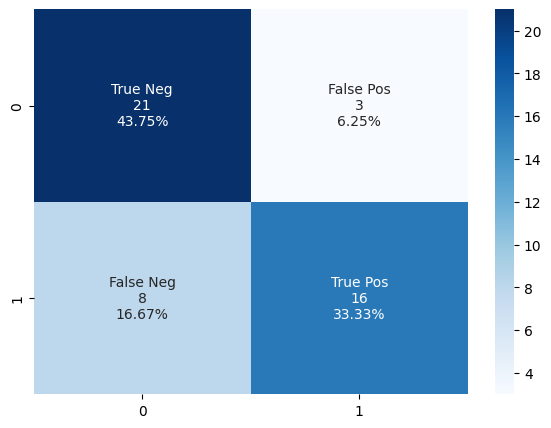

In [26]:
y_test, pred = df_rrss['label'], df_rrss['labels_0_1']
cm = confusion_matrix(y_test, pred)

confusion_matrix_visualization(cm)

In [27]:
eval_report(y_test, pred)

Accuracy score:0.7708
Balanced accuracy score:0.7708
F-1 score:0.7442
ROC-AUC score:0.7708


In [28]:
df_rrss[df_rrss.label != df_rrss.labels_0_1][['label', 'predicted_label', 'labels_0_1']]

,label,predicted_label,labels_0_1
0,1,0.249282,0
3,1,0.078369,0
5,1,0.029250,0
11,1,0.368089,0
17,1,0.027341,0
20,1,0.437078,0
21,1,0.078369,0
22,1,0.027469,0
28,0,0.585310,1
32,0,0.633391,1


In [31]:
df_rrss[['label', 'predicted_label', 'labels_0_1']]

,label,predicted_label,labels_0_1
0,1,2.492819e-01,0
1,1,9.783358e-01,1
2,1,9.991448e-01,1
3,1,7.836860e-02,0
4,1,9.364350e-01,1
5,1,2.924967e-02,0
6,1,9.901201e-01,1
7,1,9.999999e-01,1
8,1,8.827764e-01,1
9,1,9.997386e-01,1


In [ ]:
# One text test

In [34]:
df_rrss.iloc[20]['text']

'y lo que hemos hecho es una cosa simple\r\ny sencilla resolver un caso que se nos\r\nplantea y ahí está se resolvió la\r\ninscripción favorable con cuatro votos a\r\nfavor y con una abstención\r\nEh Pues es lo normal dentro de un\r\ntribunal y en un organismo colegiado eh\r\nla inscripción\r\neh está dentro los parámetros legales\r\nestá con todas las de la ley no sé por\r\nqué ser algo novedoso lo que sí es\r\ncierto es que este organismo colegiado\r\nha actuado conforme a la ley\r\n'

In [35]:
text = df_rrss.iloc[20]['text']
domain_num = df_rrss.iloc[20]['topic_new']

In [36]:
token = tokenizer(text)
tensor_domain = torch.tensor(domain_num)

In [37]:
for i in range(20):
  pred = MDFEND_MODEL(token['token_id'], token['mask'], tensor_domain)
  print(f'{i}: {pred}')

0: tensor([0.4371], grad_fn=<SigmoidBackward0>)
1: tensor([0.4371], grad_fn=<SigmoidBackward0>)
2: tensor([0.4371], grad_fn=<SigmoidBackward0>)
3: tensor([0.4371], grad_fn=<SigmoidBackward0>)
4: tensor([0.4371], grad_fn=<SigmoidBackward0>)
5: tensor([0.4371], grad_fn=<SigmoidBackward0>)
6: tensor([0.4371], grad_fn=<SigmoidBackward0>)
7: tensor([0.4371], grad_fn=<SigmoidBackward0>)
8: tensor([0.4371], grad_fn=<SigmoidBackward0>)
9: tensor([0.4371], grad_fn=<SigmoidBackward0>)
10: tensor([0.4371], grad_fn=<SigmoidBackward0>)
11: tensor([0.4371], grad_fn=<SigmoidBackward0>)
12: tensor([0.4371], grad_fn=<SigmoidBackward0>)
13: tensor([0.4371], grad_fn=<SigmoidBackward0>)
14: tensor([0.4371], grad_fn=<SigmoidBackward0>)
15: tensor([0.4371], grad_fn=<SigmoidBackward0>)
16: tensor([0.4371], grad_fn=<SigmoidBackward0>)
17: tensor([0.4371], grad_fn=<SigmoidBackward0>)
18: tensor([0.4371], grad_fn=<SigmoidBackward0>)
19: tensor([0.4371], grad_fn=<SigmoidBackward0>)


In [ ]:
# Same sample, different domains

In [38]:
for i in range(11):
  pred = MDFEND_MODEL(token['token_id'], token['mask'], torch.tensor(i)).item()
  print(f'for domain {i} prebability is: {pred:.3f}')

for domain 0 prebability is: 0.019
for domain 1 prebability is: 0.005
for domain 2 prebability is: 0.437
for domain 3 prebability is: 0.012
for domain 4 prebability is: 0.017
for domain 5 prebability is: 0.008
for domain 6 prebability is: 0.017
for domain 7 prebability is: 0.021
for domain 8 prebability is: 0.157
for domain 9 prebability is: 0.028
for domain 10 prebability is: 0.002


In [39]:
MDFEND_MODEL(token['token_id'], token['mask'], torch.tensor(i)).item()

0.0019295859383419156

In [ ]:
###